# Frequency approach, Two binary features, five binary features, Five Digitized Features, Deep neural network with scikit-learn, DNNs with TensorFlow

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Data preparation

In [2]:
NASDAQ = pd.read_csv('NASDAQ.csv')
NASDAQ.drop('Unnamed: 0',axis = 1, inplace=True)

lags = 2
def create_lags(data):
    global cols
    cols = []
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)
        data[col] = data['Log_Returns'].shift(lag)
        cols.append(col)

create_lags(NASDAQ)

NASDAQ.dropna(inplace=True)

def create_bins(data, bins=[0]):
    global cols_bin
    cols_bin = []
    for col in cols:
        col_bin = col + '_bin'
        data[col_bin] = np.digitize(data[col], bins=bins) 
        cols_bin.append(col_bin)

create_bins(NASDAQ)

NASDAQ.set_index('Date', inplace=True)

# Frequency approach

In [3]:
NASDAQ['pos_freq'] = np.where(NASDAQ[cols_bin].sum(axis=1) == 2, -1, 1)


In [4]:
(NASDAQ['direction'] == NASDAQ['pos_freq']).value_counts()

True     2901
False    2628
dtype: int64

In [5]:
NASDAQ['strat_freq'] = NASDAQ['pos_freq'] * NASDAQ['Log_Returns']

In [6]:
NASDAQ[['Log_Returns', 'strat_freq']].sum().apply(np.exp)

Log_Returns    3.030802
strat_freq     6.049369
dtype: float64

In [7]:
acc_freq = accuracy_score(NASDAQ['direction'],NASDAQ['pos_freq'])
acc_freq

0.5246880086814976

In [8]:
perf_freq = NASDAQ[['Log_Returns', 'strat_freq']].sum().apply(np.exp)
perf_freq

Log_Returns    3.030802
strat_freq     6.049369
dtype: float64

(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.]),
 [Text(-1000.0, 0, '26-02-2018'),
  Text(0.0, 0, '24-02-2000'),
  Text(1000.0, 0, '19-02-2004'),
  Text(2000.0, 0, '08-02-2008'),
  Text(3000.0, 0, '27-01-2012'),
  Text(4000.0, 0, '20-01-2016'),
  Text(5000.0, 0, '09-01-2020'),
  Text(6000.0, 0, '')])

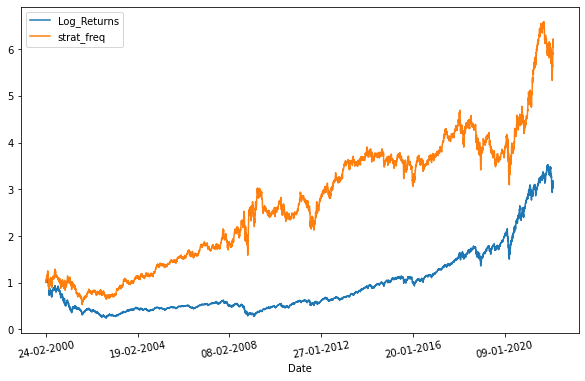

In [9]:
NASDAQ.index = pd.to_datetime(NASDAQ.index).strftime('%d-%m-%Y')
NASDAQ[['Log_Returns', 'strat_freq']].cumsum().apply(np.exp).plot(figsize=(10, 6));
NASDAQ.index = pd.to_datetime(NASDAQ.index).strftime('%d-%m-%Y')
plt.xticks(rotation=10)

# Two binary features

In [10]:
train_pct_index = int(0.7*len(NASDAQ))
train, test = NASDAQ[:train_pct_index],NASDAQ[train_pct_index:]

In [11]:
df_train = train[['Log_Returns', 'AdjClose','Close']]
df_test = test[['Log_Returns','AdjClose','Close']]

In [12]:
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

## Train

In [13]:
C = 1

models = {
'log_reg': linear_model.LogisticRegression(C=C),
'gauss_nb': GaussianNB(),
'svm': SVC(C=C)
}

In [14]:
def fit_models(data): 
    mfit = {model: models[model].fit(data[cols_bin],
    data['direction'])
    for model in models.keys()}

In [15]:
fit_models(train)

In [16]:
def derive_positions(data): 
    for model in models.keys():
        data['pos_' + model] = models[model].predict(data[cols_bin])


In [17]:
derive_positions(train)


In [18]:
df_train['TwoBinaryFeatures_log_reg'] = train['pos_log_reg']
df_train['TwoBinaryFeatures_gauss_nb'] = train['pos_gauss_nb']
df_train['TwoBinaryFeatures_svm'] = train['pos_svm']

In [19]:
def evaluate_strats(data): 
    global sel
    sel = []
    for model in models.keys():
        col = 'strat_' + model
        data[col] = data['pos_' + model] * data['Log_Returns']
        sel.append(col)
    sel.insert(0, 'Log_Returns')

In [20]:
evaluate_strats(train)

In [21]:
sel.insert(1, 'strat_freq')

In [22]:
acc2_log_reg_train = accuracy_score(train['direction'],train['pos_log_reg'])
print('Accuracy log_reg:', acc2_log_reg_train)
acc2_gauss_nb_train = accuracy_score(train['direction'],train['pos_gauss_nb'])
print('Accuracy gauss_nb:', acc2_gauss_nb_train)
acc2_svm_train = accuracy_score(train['direction'],train['pos_svm'])
print('Accuracy svm:', acc2_svm_train)

Accuracy log_reg: 0.5341085271317829
Accuracy gauss_nb: 0.5341085271317829
Accuracy svm: 0.5341085271317829


In [23]:
two_perf_train = train[sel].sum().apply(np.exp)
two_perf_train

Log_Returns       1.121873
strat_freq        3.624633
strat_log_reg     1.121873
strat_gauss_nb    1.121873
strat_svm         1.121873
dtype: float64

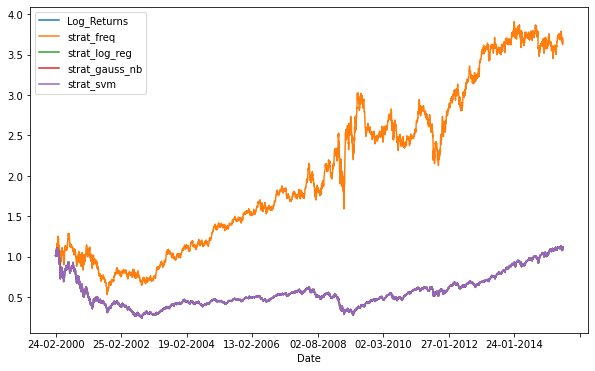

In [24]:
train[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));

## Test

In [25]:
derive_positions(test)

In [26]:
df_test['TwoBinaryFeatures_log_reg'] = test['pos_log_reg']
df_test['TwoBinaryFeatures_gauss_nb'] = test['pos_gauss_nb']
df_test['TwoBinaryFeatures_svm'] = test['pos_svm']

In [27]:
evaluate_strats(test)

In [28]:
sel.insert(1, 'strat_freq')

In [29]:
acc2_log_reg_test = accuracy_score(test['direction'],test['pos_log_reg'])
print('Accuracy log_reg:', acc2_log_reg_test)
acc2_gauss_nb_test = accuracy_score(test['direction'],test['pos_gauss_nb'])
print('Accuracy gauss_nb:', acc2_gauss_nb_test)
acc2_svm_test = accuracy_score(test['direction'],test['pos_svm'])
print('Accuracy svm:', acc2_svm_test)

Accuracy log_reg: 0.5666063893911996
Accuracy gauss_nb: 0.5666063893911996
Accuracy svm: 0.5666063893911996


In [30]:
two_perf_test = test[sel].sum().apply(np.exp)
two_perf_test

Log_Returns       2.701557
strat_freq        1.668961
strat_log_reg     2.701557
strat_gauss_nb    2.701557
strat_svm         2.701557
dtype: float64

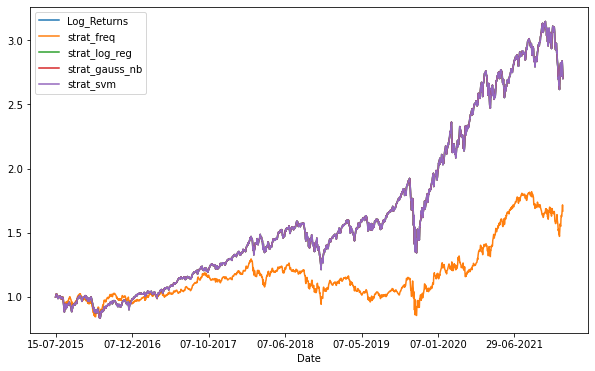

In [31]:
test[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));

# Five binary features

## Train

In [32]:
lags = 5 
create_lags(train)
train.dropna(inplace=True)

In [33]:
create_bins(train) 
cols_bin

['lag_1_bin', 'lag_2_bin', 'lag_3_bin', 'lag_4_bin', 'lag_5_bin']

In [34]:
train[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
03-02-2000,1,1,0,0,1
03-03-2000,0,1,1,0,0
03-06-2000,1,0,1,1,0
03-07-2000,0,1,0,1,1
03-08-2000,0,0,1,0,1


In [35]:
fit_models(train)

In [36]:
derive_positions(train)

In [37]:
df_train['FiveBinaryFeatures_log_reg'] = train['pos_log_reg']
df_train['FiveBinaryFeatures_gauss_nb'] = train['pos_gauss_nb']
df_train['FiveBinaryFeatures_svm'] = train['pos_svm']

In [38]:
evaluate_strats(train)

In [39]:
acc5_log_reg_train = accuracy_score(train['direction'],train['pos_log_reg'])
print('Accuracy log_reg:', acc5_log_reg_train)
acc5_gauss_nb_train = accuracy_score(train['direction'],train['pos_gauss_nb'])
print('Accuracy gauss_nb:', acc5_gauss_nb_train)
acc5_svm_train = accuracy_score(train['direction'],train['pos_svm'])
print('Accuracy svm:', acc5_svm_train)

Accuracy log_reg: 0.5340232858990944
Accuracy gauss_nb: 0.5340232858990944
Accuracy svm: 0.5435963777490298


In [40]:
five_perf_train = train[sel].sum().apply(np.exp)
five_perf_train

Log_Returns       1.067058
strat_log_reg     1.067058
strat_gauss_nb    1.067058
strat_svm         7.823082
dtype: float64

<AxesSubplot:xlabel='Date'>

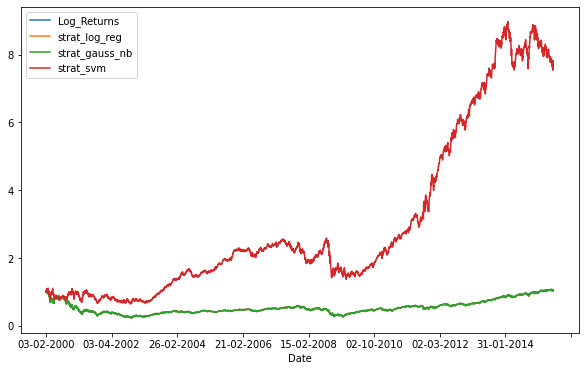

In [41]:
train[sel].cumsum().apply(np.exp).plot(figsize=(10, 6))

## Test

In [42]:
lags = 5 
create_lags(test)
test.dropna(inplace=True)
create_bins(test) 
derive_positions(test)

In [43]:
df_test['FiveBinaryFeatures_log_reg'] = test['pos_log_reg']
df_test['FiveBinaryFeatures_gauss_nb'] = test['pos_gauss_nb']
df_test['FiveBinaryFeatures_svm'] = test['pos_svm']

In [44]:
evaluate_strats(test)

In [45]:
acc5_log_reg_test = accuracy_score(test['direction'],test['pos_log_reg'])
print('Accuracy log_reg:', acc5_log_reg_test)
acc5_gauss_nb_test = accuracy_score(test['direction'],test['pos_gauss_nb'])
print('Accuracy gauss_nb:', acc5_gauss_nb_test)
acc5_svm_test = accuracy_score(test['direction'],test['pos_svm'])
print('Accuracy svm:', acc5_svm_test)

Accuracy log_reg: 0.5665054413542926
Accuracy gauss_nb: 0.5665054413542926
Accuracy svm: 0.5417170495767836


In [46]:
five_perf_test = test[sel].sum().apply(np.exp)
five_perf_test

Log_Returns       2.648009
strat_log_reg     2.648009
strat_gauss_nb    2.648009
strat_svm         0.808475
dtype: float64

<AxesSubplot:xlabel='Date'>

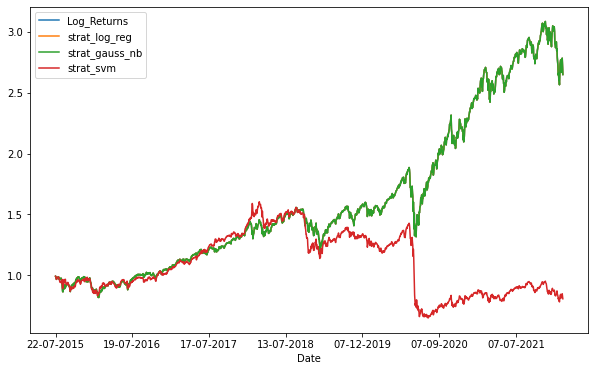

In [47]:
test[sel].cumsum().apply(np.exp).plot(figsize=(10, 6))

# Five Digitized Features

## Train

In [48]:
mu = train['Log_Returns'].mean() 
v = train['Log_Returns'].std()

In [49]:
bins = [mu - v, mu, mu + v] 
bins

[-0.01669920893273494, 1.6793065614489e-05, 0.016732795063963923]

In [50]:
create_bins(train, bins)

In [51]:
fit_models(train)

In [52]:
derive_positions(train)


In [53]:
df_train['FiveDigitizedFeatures_log_reg'] = train['pos_log_reg']
df_train['FiveDigitizedFeatures_gauss_nb'] = train['pos_gauss_nb']
df_train['FiveDigitizedFeatures_svm'] = train['pos_svm']

In [54]:
evaluate_strats(train)

In [55]:
accdf_log_reg_train = accuracy_score(train['direction'],train['pos_log_reg'])
print('Accuracy log_reg:', accdf_log_reg_train)
accdf_gauss_nb_train = accuracy_score(train['direction'],train['pos_gauss_nb'])
print('Accuracy gauss_nb:', accdf_gauss_nb_train)
accdf_svm_train = accuracy_score(train['direction'],train['pos_svm'])
print('Accuracy svm:', accdf_svm_train)

Accuracy log_reg: 0.535575679172057
Accuracy gauss_nb: 0.5366106080206986
Accuracy svm: 0.5790426908150065


In [56]:
df_perf_train = train[sel].sum().apply(np.exp)
df_perf_train

Log_Returns          1.067058
strat_log_reg        1.431963
strat_gauss_nb       1.250562
strat_svm         1618.729761
dtype: float64

<AxesSubplot:xlabel='Date'>

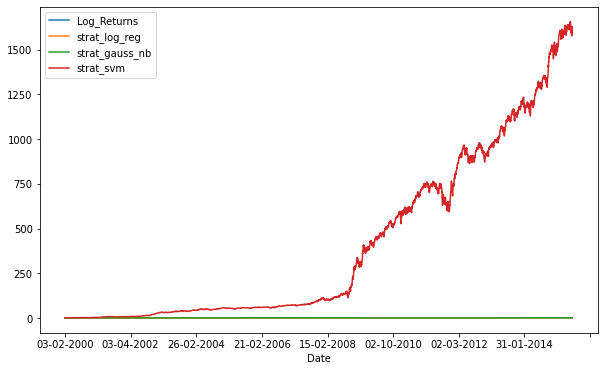

In [57]:
train[sel].cumsum().apply(np.exp).plot(figsize=(10, 6))

## Test

In [58]:
mu = test['Log_Returns'].mean() 
v = test['Log_Returns'].std()
bins = [mu - v, mu, mu + v] 
create_bins(test, bins)
derive_positions(test)
evaluate_strats(test)

In [59]:
df_test['FiveDigitizedFeatures_log_reg'] = test['pos_log_reg']
df_test['FiveDigitizedFeatures_gauss_nb'] = test['pos_gauss_nb']
df_test['FiveDigitizedFeatures_svm'] = test['pos_svm']

In [60]:
accdf_log_reg_test = accuracy_score(test['direction'],test['pos_log_reg'])
print('Accuracy log_reg:', accdf_log_reg_test)
accdf_gauss_nb_test = accuracy_score(test['direction'],test['pos_gauss_nb'])
print('Accuracy gauss_nb:', accdf_gauss_nb_test)
accdf_svm_test = accuracy_score(test['direction'],test['pos_svm'])
print('Accuracy svm:', accdf_svm_test)

Accuracy log_reg: 0.5671100362756953
Accuracy gauss_nb: 0.532043530834341
Accuracy svm: 0.5489721886336155


In [61]:
df_perf_test = test[sel].sum().apply(np.exp)
df_perf_test

Log_Returns       2.648009
strat_log_reg     2.739989
strat_gauss_nb    0.622602
strat_svm         1.553291
dtype: float64

In [62]:
import matplotlib.pyplot as plt

(array([-250.,    0.,  250.,  500.,  750., 1000., 1250., 1500., 1750.]),
 [Text(-250.0, 0, '18-02-2021'),
  Text(0.0, 0, '22-07-2015'),
  Text(250.0, 0, '19-07-2016'),
  Text(500.0, 0, '17-07-2017'),
  Text(750.0, 0, '13-07-2018'),
  Text(1000.0, 0, '12-07-2019'),
  Text(1250.0, 0, '09-07-2020'),
  Text(1500.0, 0, '07-07-2021'),
  Text(1750.0, 0, '')])

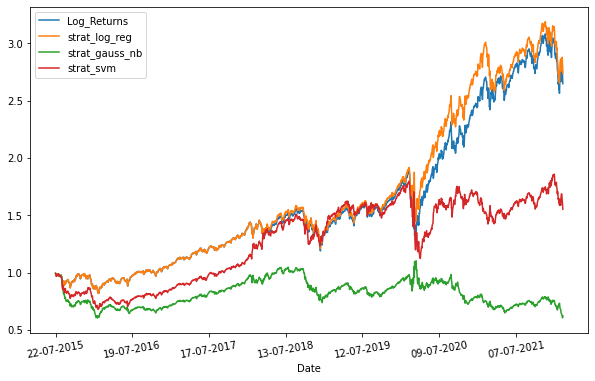

In [63]:
test.index = pd.to_datetime(test.index).strftime('%d-%m-%Y')
test[sel].cumsum().apply(np.exp).plot(figsize=(10, 6))
plt.xticks(rotation=10)

# Deep neural network with scikit-learn

In [64]:
from sklearn.neural_network import MLPClassifier

In [65]:
model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=2 * [250], random_state=1) #Alpha? random_state?

In [66]:
model.fit(train[cols_bin], train['direction'])

MLPClassifier(alpha=1e-05, hidden_layer_sizes=[250, 250], random_state=1,
              solver='lbfgs')

In [67]:
train['pos_dnn_sk'] = model.predict(train[cols_bin])

In [68]:
DNN_Scikit_train = accuracy_score(train['direction'],train['pos_dnn_sk'])
DNN_Scikit_train

0.6333764553686934

In [69]:
train['strat_dnn_sk'] = train['pos_dnn_sk'] * train['Log_Returns']

In [70]:
Scikit_perf_train = train[['Log_Returns', 'strat_dnn_sk']].sum().apply(np.exp)
Scikit_perf_train

Log_Returns     1.067058e+00
strat_dnn_sk    1.373333e+06
dtype: float64

<AxesSubplot:xlabel='Date'>

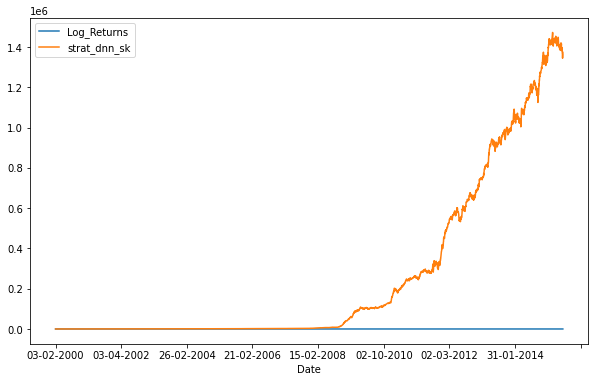

In [71]:
train[['Log_Returns', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10, 6))

#va da dio ma c'è palese overfitting quindi bisogna fare train e test,magari con randomizzazione shuffle

## Test

In [72]:
test['pos_dnn_sk'] = model.predict(test[cols_bin])
DNN_Scikit_test = accuracy_score(test['direction'],test['pos_dnn_sk'])
DNN_Scikit_test

0.5193470374848851

In [73]:
test['strat_dnn_sk'] = test['pos_dnn_sk'] * test['Log_Returns']
Scikit_perf_test = test[['Log_Returns', 'strat_dnn_sk']].sum().apply(np.exp)
Scikit_perf_test

Log_Returns     2.648009
strat_dnn_sk    1.014186
dtype: float64

<AxesSubplot:xlabel='Date'>

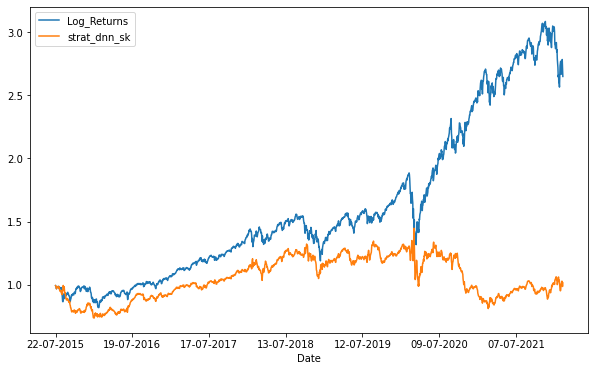

In [74]:
test[['Log_Returns', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10, 6))

# DNNs with TensorFlow

## Train

In [75]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

In [76]:
fc = [tf.contrib.layers.real_valued_column('lags', dimension=lags)]

In [77]:
model = tf.contrib.learn.DNNClassifier(hidden_units=3 * [500], n_classes=len(bins) + 1, feature_columns=fc)


In [78]:
def input_fn():
    fc = {'lags': tf.constant(train[cols_bin].values)}
    la = tf.constant(train['direction'].apply(lambda x: 0 if x < 0 else 1).values, shape=[train['direction'].size, 1])
    return fc, la

In [79]:
model.fit(input_fn=input_fn, steps=250)

DNNClassifier(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._MultiClassHead object at 0x000001F40A76A5F8>, 'hidden_units': [500, 500, 500], 'feature_columns': (_RealValuedColumn(column_name='lags', dimension=5, default_value=None, dtype=tf.float32, normalizer=None),), 'optimizer': None, 'activation_fn': <function relu at 0x000001F4035A5510>, 'dropout': None, 'gradient_clip_norm': None, 'embedding_lr_multipliers': None, 'input_layer_min_slice_size': None})

In [80]:
model.evaluate(input_fn=input_fn, steps=1)

{'loss': 0.6883708, 'accuracy': 0.55084085, 'global_step': 250}

In [81]:
pred = np.array(list(model.predict(input_fn=input_fn))) 
pred[:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [82]:
train['pos_dnn_tf'] = np.where(pred == 0, 1, -1)

In [83]:
DNN_tens_train = accuracy_score(train['direction'],train['pos_dnn_tf'])
DNN_tens_train

0.44915912031047867

In [84]:
train['strat_dnn_tf'] = train['pos_dnn_tf'] * train['Log_Returns']


In [85]:
tens_perf_train = train[['Log_Returns', 'strat_dnn_tf']].sum().apply(np.exp)
tens_perf_train

Log_Returns     1.067058
strat_dnn_tf    0.032263
dtype: float64

<AxesSubplot:xlabel='Date'>

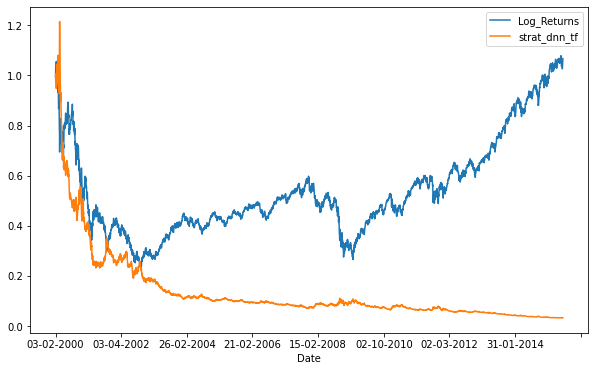

In [86]:
train[['Log_Returns', 'strat_dnn_tf']].cumsum().apply(np.exp).plot(figsize=(10, 6))

## Test

In [87]:
def input_fn():
    fc = {'lags': tf.constant(test[cols_bin].values)}
    la = tf.constant(test['direction'].apply(lambda x: 0 if x < 0 else 1).values, shape=[test['direction'].size, 1])
    return fc, la

model.evaluate(input_fn=input_fn, steps=1)

pred = np.array(list(model.predict(input_fn=input_fn)))

test['pos_dnn_tf'] = np.where(pred == 0, 1, -1)

DNN_tens_test = accuracy_score(test['direction'],test['pos_dnn_tf'])
DNN_tens_test

0.44014510278113667

In [88]:
test['strat_dnn_tf'] = test['pos_dnn_tf'] * test['Log_Returns']

tens_perf_test = test[['Log_Returns', 'strat_dnn_tf']].sum().apply(np.exp)
tens_perf_test

Log_Returns     2.648009
strat_dnn_tf    0.488889
dtype: float64

<AxesSubplot:xlabel='Date'>

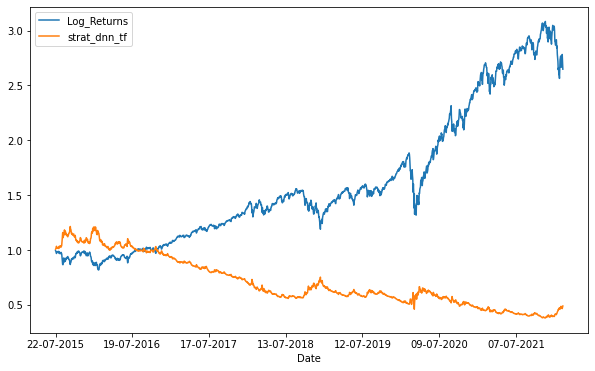

In [89]:
test[['Log_Returns', 'strat_dnn_tf']].cumsum().apply(np.exp).plot(figsize=(10, 6))

# Matrix accuracy and performance

In [90]:
data_two = {'Algorithm': ['Two Log','Two frequency approach','Two Bin fea log_reg', 'Two Bin fea gauss_nb', 'Two Bin fea svm'], 
        'Accuracy_train': [np.NaN,np.NaN,acc2_log_reg_train,acc2_gauss_nb_train,acc2_svm_train], 
        'Accuracy_test' : [np.NaN,np.NaN,acc2_log_reg_test,acc2_gauss_nb_test,acc2_svm_test],
        'Performance_train': [two_perf_train[0],two_perf_train[1],two_perf_train[2],two_perf_train[3],two_perf_train[4]],
        'Performance_test' : [two_perf_test[0],two_perf_test[1],two_perf_test[2],two_perf_test[3],two_perf_test[4]]}
table_two_bin = pd.DataFrame(data_two)

In [91]:
data_five = {'Algorithm': ['five Log','five Bin fea log_reg', 'five Bin fea gauss_nb', 'five Bin fea svm'], 
        'Accuracy_train': [np.NaN,acc5_log_reg_train,acc5_gauss_nb_train,acc5_svm_train], 
        'Accuracy_test' : [np.NaN,acc5_log_reg_test,acc5_gauss_nb_test,acc5_svm_test],
        'Performance_train': [five_perf_train[0],five_perf_train[1],five_perf_train[2],five_perf_train[3]],
        'Performance_test' : [five_perf_test[0],five_perf_test[1],five_perf_test[2],five_perf_test[3]]}
table_five_bin = pd.DataFrame(data_five)

In [92]:
data_df = {'Algorithm': ['df log_reg', 'df gauss_nb', 'df svm'], 
        'Accuracy_train': [accdf_log_reg_train,accdf_gauss_nb_train,accdf_svm_train], 
        'Accuracy_test' : [accdf_log_reg_test,accdf_gauss_nb_test,accdf_svm_test],
        'Performance_train': [df_perf_train[1],df_perf_train[2],df_perf_train[3]],
        'Performance_test' : [df_perf_test[1],df_perf_test[2],df_perf_test[3]]}
table_df= pd.DataFrame(data_df)

In [93]:
data_DNN_Scikit = {'Algorithm': ['DNN Scikit Learn'], 
        'Accuracy_train': [DNN_Scikit_train], 
        'Accuracy_test' : [DNN_Scikit_test],
        'Performance_train': [Scikit_perf_train[1]],
        'Performance_test' : [Scikit_perf_test[1]]}
table_DNN_Scikit = pd.DataFrame(data_DNN_Scikit)

In [94]:
data_DNN_tens = {'Algorithm': ['DNN Tensorflow'], 
        'Accuracy_train': [DNN_tens_train], 
        'Accuracy_test' : [DNN_tens_test],
        'Performance_train': [tens_perf_train[1]],
        'Performance_test' : [tens_perf_test[1]]}
table_DNN_tens = pd.DataFrame(data_DNN_tens)

In [95]:
matrix = pd.concat([table_two_bin, table_five_bin, table_df, table_DNN_Scikit, table_DNN_tens])
matrix.reset_index(drop=True, inplace= True)
pd.options.display.float_format = '{:.5f}'.format

In [96]:
matrix

,Algorithm,Accuracy_train,Accuracy_test,Performance_train,Performance_test
0,Two Log,nan,nan,1.12187,2.70156
1,Two frequency approach,nan,nan,3.62463,1.66896
2,Two Bin fea log_reg,0.53411,0.56661,1.12187,2.70156
3,Two Bin fea gauss_nb,0.53411,0.56661,1.12187,2.70156
4,Two Bin fea svm,0.53411,0.56661,1.12187,2.70156
5,five Log,nan,nan,1.06706,2.64801
6,five Bin fea log_reg,0.53402,0.56651,1.06706,2.64801
7,five Bin fea gauss_nb,0.53402,0.56651,1.06706,2.64801
8,five Bin fea svm,0.54360,0.54172,7.82308,0.80847
9,df log_reg,0.53558,0.56711,1.43196,2.73999


In [97]:
df_train['DNN_scikit'] = train['pos_dnn_sk']
df_train['DNN_Tensorflow'] = train['pos_dnn_tf']

In [98]:
df_test['DNN_scikit'] = test['pos_dnn_sk']
df_test['DNN_Tensorflow'] = test['pos_dnn_tf']

In [99]:
df_train.dropna(inplace = True)
df_test.dropna(inplace = True)

In [100]:
df_train.to_csv('Strategy_NASDAQ_train.csv')
df_test.to_csv('Strategy_NASDAQ_test.csv')